In [1]:

# Установка библиотек (для Colab)
!pip install catboost pymorphy3 openpyxl --quiet


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pymorphy3 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report


## 1. Загрузка данных и первичный анализ

In [3]:

df = pd.read_excel('data.xlsx')
display(df.head())
print(df.info())


,text,category,priority
0,Клиент требует расторгнуть договор “по личным ...,1,2
1,"Коллекторы шантажируют, хотя я подал заявление...",3,3
2,Срочно нужно расторгнуть договор с подрядчиком...,1,3
3,"Оказал услугу, клиент требует возврат, хотя вс...",1,2
4,"Все долги перед МФО. Есть ли шанс на списание,...",3,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      608 non-null    object
 1   category  608 non-null    int64 
 2   priority  608 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.4+ KB
None


## 2. Исследовательский анализ данных

In [4]:

print('Количество обращений:', len(df))
print('Уникальные категории:', df['category'].unique())
print('Распределение по категориям:')
print(df['category'].value_counts())
print('\nРаспределение по приоритету:')
print(df['priority'].value_counts())


Количество обращений: 608
Уникальные категории: [1 3 2]
Распределение по категориям:
category
1    215
2    211
3    182
Name: count, dtype: int64

Распределение по приоритету:
priority
2    301
3    229
1     78
Name: count, dtype: int64


## 3. Предобработка текста

In [5]:

russian_stopwords = set("""
и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один почти мой тем чтобы нее зачем вас они
""".split())

morph = MorphAnalyzer()
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^а-яa-zё ]", " ", text)
    tokens = text.split()
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    lemmas = [lemma for lemma in lemmas if lemma not in russian_stopwords and len(lemma) > 2]
    return ' '.join(lemmas)

df['text_processed'] = df['text'].apply(preprocess_text)
df[['text', 'text_processed']].head()


,text,text_processed
0,Клиент требует расторгнуть договор “по личным ...,клиент требовать расторгнуть договор личный пр...
1,"Коллекторы шантажируют, хотя я подал заявление...",коллектор шантажировать хотя подать заявление ...
2,Срочно нужно расторгнуть договор с подрядчиком...,срочно нужно расторгнуть договор подрядчик кот...
3,"Оказал услугу, клиент требует возврат, хотя вс...",оказать услуга клиент требовать возврат хотя в...
4,"Все долги перед МФО. Есть ли шанс на списание,...",всё долг перед мфо шанс списание хороший рестр...


## 4. Векторизация текстов

In [6]:

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text_processed'])


## 5. Классификация по категориям

In [7]:

X = X_tfidf
y_category = df['category']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_category, test_size=0.2, random_state=42, stratify=y_category)

models_cat = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

results_cat = {}
for name, model in models_cat.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    f1 = f1_score(y_test_c, y_pred, average='macro')
    results_cat[name] = f1

best_cat_name = max(results_cat, key=results_cat.get)
best_cat_model = models_cat[best_cat_name]
y_pred_best_cat = best_cat_model.predict(X_test_c)

print("Категория — F1_macro:")
for name, score in results_cat.items():
    print(f"{name}: {score:.3f}")
print(f"Лучшая модель: {best_cat_name}")


Категория — F1_macro:
Logistic Regression: 0.984
Naive Bayes: 0.984
Random Forest: 0.976
CatBoost: 0.937
Лучшая модель: Logistic Regression


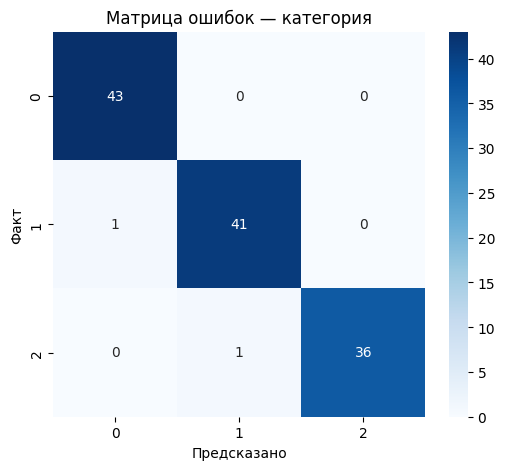


Отчёт по классам:
              precision    recall  f1-score   support

           1      0.977     1.000     0.989        43
           2      0.976     0.976     0.976        42
           3      1.000     0.973     0.986        37

    accuracy                          0.984       122
   macro avg      0.984     0.983     0.984       122
weighted avg      0.984     0.984     0.984       122



In [8]:

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_c, y_pred_best_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Факт')
plt.title('Матрица ошибок — категория')
plt.show()
print("\nОтчёт по классам:")
print(classification_report(y_test_c, y_pred_best_cat, digits=3))


## 6. Классификация по приоритету — тест всех моделей

In [9]:

y_priority = df['priority']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_priority, test_size=0.2, random_state=42, stratify=y_priority)

models_pri = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

results_pri = {}
recall3_pri = {}
for name, model in models_pri.items():
    model.fit(X_train_p, y_train_p)
    y_pred = model.predict(X_test_p)
    f1 = f1_score(y_test_p, y_pred, average='macro')
    recall_3 = recall_score(y_test_p, y_pred, labels=[3], average='macro', zero_division=0)
    results_pri[name] = f1
    recall3_pri[name] = recall_3

best_pri_name = max(results_pri, key=results_pri.get)
best_pri_model = models_pri[best_pri_name]
y_pred_best_pri = best_pri_model.predict(X_test_p)

print("Приоритет — F1_macro:")
for name, score in results_pri.items():
    print(f"{name}: {score:.3f}")
print("Приоритет — Recall по классу 3:")
for name, score in recall3_pri.items():
    print(f"{name}: {score:.3f}")
print(f"Лучшая модель (F1_macro): {best_pri_name}")


Приоритет — F1_macro:
Logistic Regression: 0.399
Naive Bayes: 0.431
Random Forest: 0.421
CatBoost: 0.472
Приоритет — Recall по классу 3:
Logistic Regression: 0.435
Naive Bayes: 0.478
Random Forest: 0.478
CatBoost: 0.522
Лучшая модель (F1_macro): CatBoost


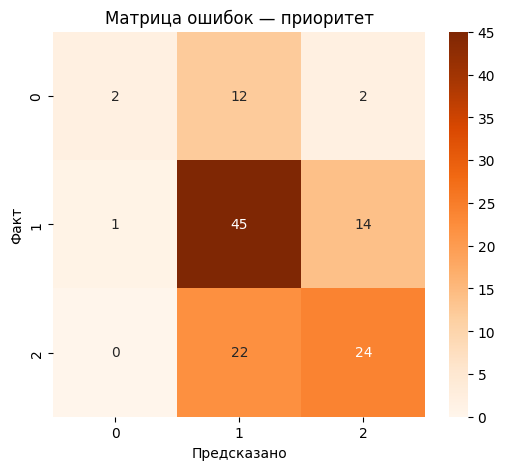


Отчёт по классам:
              precision    recall  f1-score   support

           1      0.667     0.125     0.211        16
           2      0.570     0.750     0.647        60
           3      0.600     0.522     0.558        46

    accuracy                          0.582       122
   macro avg      0.612     0.466     0.472       122
weighted avg      0.594     0.582     0.556       122



In [10]:

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_p, y_pred_best_pri)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Предсказано')
plt.ylabel('Факт')
plt.title('Матрица ошибок — приоритет')
plt.show()
print("\nОтчёт по классам:")
print(classification_report(y_test_p, y_pred_best_pri, digits=3))


## 7. Эксперименты по улучшению приоритизации (CatBoost)

### Эксперимент 1: CatBoost + длина текста и has_urgent

In [11]:

df['text_len'] = df['text_processed'].apply(lambda x: len(x.split()))
urgent_words = ['срочно', 'угрожают', 'угроза', 'немедленно']
df['has_urgent'] = df['text_processed'].apply(lambda x: int(any(word in x for word in urgent_words)))

X_exp1 = pd.DataFrame(X_tfidf.toarray())
X_exp1['text_len'] = df['text_len']
X_exp1['has_urgent'] = df['has_urgent']
X_train_e1, X_test_e1, y_train_e1, y_test_e1 = train_test_split(X_exp1, y_priority, test_size=0.2, random_state=42, stratify=y_priority)

model_exp1 = CatBoostClassifier(verbose=0, random_state=42)
model_exp1.fit(X_train_e1, y_train_e1)
y_pred_e1 = model_exp1.predict(X_test_e1)
f1_e1 = f1_score(y_test_e1, y_pred_e1, average='macro')
recall_3_e1 = recall_score(y_test_e1, y_pred_e1, labels=[3], average='macro', zero_division=0)
print(f"CatBoost + признаки: F1_macro = {f1_e1:.3f}, Recall (класс 3) = {recall_3_e1:.3f}")


CatBoost + признаки: F1_macro = 0.504, Recall (класс 3) = 0.522


### Эксперимент 2: CatBoost + TF-IDF с биграммами

In [12]:

tfidf_bi = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_tfidf_bi = tfidf_bi.fit_transform(df['text_processed'])
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_tfidf_bi, y_priority, test_size=0.2, random_state=42, stratify=y_priority)

model_exp2 = CatBoostClassifier(verbose=0, random_state=42)
model_exp2.fit(X_train_bi, y_train_bi)
y_pred_bi = model_exp2.predict(X_test_bi)
f1_bi = f1_score(y_test_bi, y_pred_bi, average='macro')
recall_3_bi = recall_score(y_test_bi, y_pred_bi, labels=[3], average='macro', zero_division=0)
print(f"CatBoost + биграммы: F1_macro = {f1_bi:.3f}, Recall (класс 3) = {recall_3_bi:.3f}")


CatBoost + биграммы: F1_macro = 0.465, Recall (класс 3) = 0.500


### Эксперимент 3: CatBoost (обычный TF-IDF) + смещение порога

In [14]:

probas = best_pri_model.predict_proba(X_test_p)
y_pred_thr = np.array([3 if p[2] > 0.3 else np.argmax(p)+1 for p in probas])
f1_thr = f1_score(y_test_p, y_pred_thr, average='macro')
recall_3_thr = recall_score(y_test_p, y_pred_thr, labels=[3], average='macro', zero_division=0)
print(f"CatBoost + смещение порога: F1_macro = {f1_thr:.3f}, Recall (класс 3) = {recall_3_thr:.3f}")


CatBoost + смещение порога: F1_macro = 0.468, Recall (класс 3) = 0.696


## 8. Краткий вывод


В ноутбуке реализованы: полный цикл предобработки, тест всех моделей для обеих задач, построение матриц ошибок, а также серия экспериментов по улучшению приоритизации. Все этапы снабжены вычислением ключевых метрик и комментариями для практической работы.


In [15]:
import pickle

# Сохраняем TF-IDF векторизатор
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Сохраняем Logistic Regression (модель по категориям)
with open('logreg_category.pkl', 'wb') as f:
    pickle.dump(best_cat_model, f)

# Сохраняем CatBoost (модель по приоритету)
best_catboost_model = best_pri_model
best_catboost_model.save_model('catboost_priority.cbm')
